<a href="https://colab.research.google.com/github/iris-kurapaty/CodingPractice/blob/main/Step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

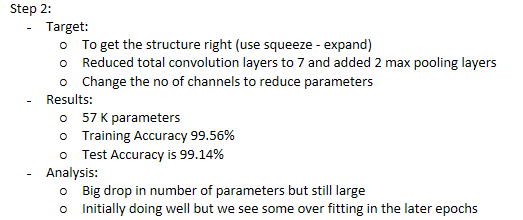

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 88916026.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98725096.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25277658.00it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3788887.98it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


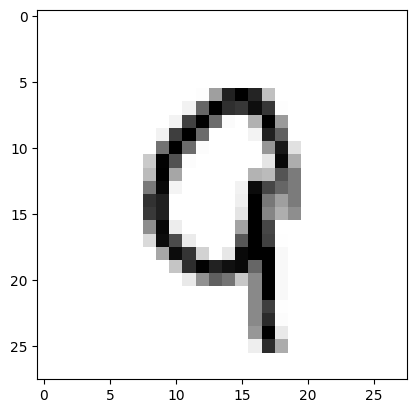

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


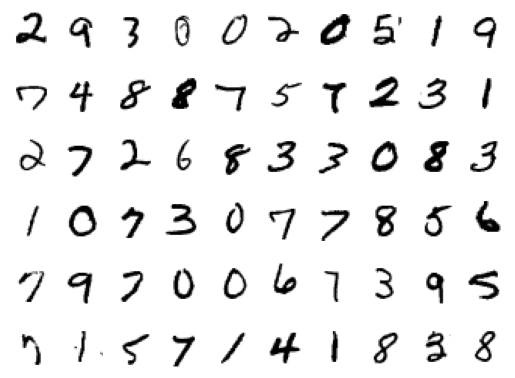

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 28>28 | 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 28 > 28 |  5
        self.pool1 = nn.MaxPool2d(2, 2) # 28 > 14 | 10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 14> 14 | 12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #14 > 14 | 14
        self.pool2 = nn.MaxPool2d(2, 2) # 14 > 7 | 28
        self.conv5 = nn.Conv2d(256, 512, 3) # 7 > 5 | 30
        self.conv6 = nn.Conv2d(512, 1024, 3) # 5 > 3 | 32 | 3*3*1024 | 3x3x1024x10 |
        self.conv7 = nn.Conv2d(1024, 10, 3) # 3 > 1 | 34 | > 1x1x10

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

# Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06851445138454437 Batch_id=468 Accuracy=88.95: 100%|██████████| 469/469 [00:25<00:00, 18.66it/s]



Test set: Average loss: 0.0488, Accuracy: 9853/10000 (98.53%)

EPOCH: 1


Loss=0.05000532045960426 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]



Test set: Average loss: 0.0388, Accuracy: 9880/10000 (98.80%)

EPOCH: 2


Loss=0.0545482337474823 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]



Test set: Average loss: 0.0311, Accuracy: 9902/10000 (99.02%)

EPOCH: 3


Loss=0.008578612469136715 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]



Test set: Average loss: 0.0347, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.08033778518438339 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]



Test set: Average loss: 0.0355, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.003626425052061677 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]



Test set: Average loss: 0.0312, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.010531737469136715 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]



Test set: Average loss: 0.0287, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.005588490981608629 Batch_id=118 Accuracy=99.84:  25%|██▍       | 117/469 [00:05<00:14, 24.81it/s]

In [ ]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

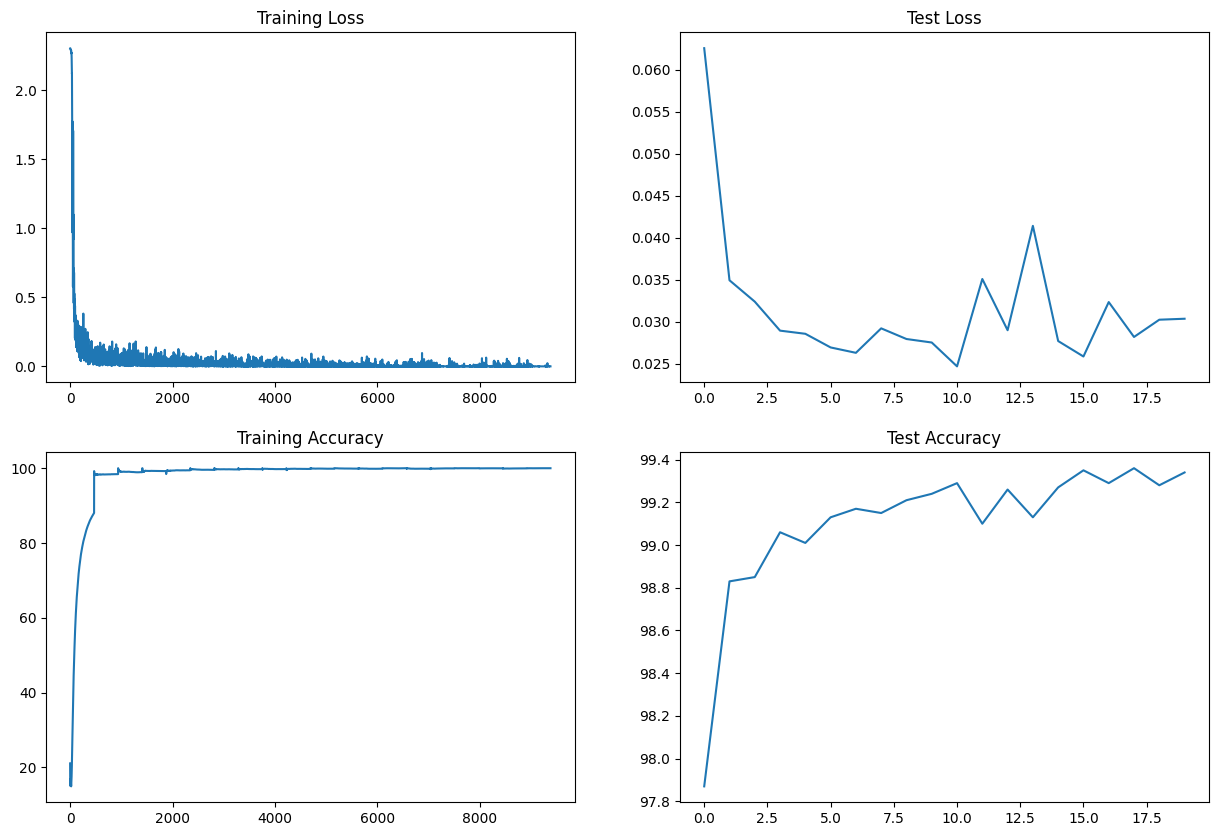

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")